### 1 : Importing Libraries

In [1]:
# ignore the warnings in the output
import warnings
warnings.filterwarnings("ignore")

In [2]:
# import libraries and packages
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import mlflow
from pycaret.classification import *

import sqlite3

 ### 2 Reading Data

In [3]:
##Copy the cleaned data obtained from the data_cleaning notebook into the Data folder before proceeding
%time
dataset = pd.read_csv('Data/cleaned_data.csv')

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.2 µs


In [4]:
dataset.head()

,created_date,city_tier,first_platform_c,first_utm_medium_c,first_utm_source_c,total_leads_droppped,referred_lead,app_complete_flag,assistance_interaction,career_interaction,payment_interaction,social_interaction,syllabus_interaction
0,2021-07-01 00:08:15,1.0,Level0,Level11,Level2,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
1,2021-07-01 00:16:43,2.0,Level3,Level0,others,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
2,2021-07-01 00:22:20,1.0,Level3,Level0,Level0,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
3,2021-07-01 00:23:13,1.0,Level1,Level3,others,2.0,0.0,0,0.0,0.0,0.0,0.0,0.0
4,2021-07-01 00:28:38,1.0,Level3,Level0,Level0,1.0,0.0,0,0.0,0.0,0.0,0.0,0.0


In [5]:
# drop the data column as it is not needed for training
dataset = dataset.drop(['created_date'], axis=1)

### 3 Setting up Environment: 

In [9]:
# create a connection and setup a SQLite database with the name "lead_scoring_model_experimentation.db" in 
# 'Assignment/02_training_pipeline/notebooks/' location

In [6]:
#import importlib.util

In [10]:
'''
def module_from_file(module_name, file_path):
    spec = importlib.util.spec_from_file_location(module_name, file_path)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)
    return module
'''

'\ndef module_from_file(module_name, file_path):\n    spec = importlib.util.spec_from_file_location(module_name, file_path)\n    module = importlib.util.module_from_spec(spec)\n    spec.loader.exec_module(module)\n    return module\n'

In [11]:
#utils = module_from_file("utils", "/home/Assignment/01_data_pipeline/scripts/utils.py")
#utils2 = module_from_file("utils", "/home/Assignment/02_training_pipeline/scripts/utils.py")



In [12]:
db_path = "/home/Assignment/02_training_pipeline/notebooks/"
db_file_name = "lead_scoring_model_experimentation.db"

In [15]:
#create DB
import os

if os.path.isfile(db_path+db_file_name):
    print( "DB Already Exist")
    print(os.getcwd())
else:
    print ("Creating Database")
    """ create a database connection to a SQLite database """
    conn = None
    try:
        conn = sqlite3.connect(db_path+db_file_name)
        print("New DB Created")
    except Error as e:
        print(e)
        print("Error")
    finally:
        if conn:
            conn.close()
            print("DB Created")



Creating Database
New DB Created
DB Created


In [16]:
cnx = sqlite3.connect(db_path + db_file_name)
df = pd.read_sql(f"SELECT name FROM sqlite_master WHERE type='table'", cnx)
print(df.shape)
df.head(16)

(0, 1)


,name


In [17]:
'''
Now you need to start the MLflow server in a new terminal. 
Note: Before you start the MLflow server, create a folder named mlruns in the assignment directory.
Now you need to run the command to start MLflow server such that:
1. The lead_scoring_model_experimentation.db which you created above is used as the backend-store.
2. mlruns folder is used as an artifact directory. 
3. The server runs on the port 6006.

The steps to do so are as follows:
Open a new terminal.
Then go to the Assignment directory using the cd command. Type the command: cd Assignment/
Create a folder named mlruns here. You can create this folder using either the command line or GUI. To create this folder via the command line run the command: mkdir ./mlruns
Then, type the following command to start the MLflow server: 
mlflow server --backend-store-uri='sqlite:///./02_training_pipeline/notebooks/lead_scoring_model_experimentation.db' --default-artifact-root="./mlruns" --port=6006 --host=0.0.0.0

mlflow server --backend-store-uri='sqlite:///./02_training_pipeline/notebooks/lead_scoring_model_experimentation.db' --default-artifact-root="/home/Assignment/mlruns" --port=6006 --host=0.0.0.0

Akash
inside - Assignment/02_training_pipeline/notebooks/mlruns
in assignment - /home/Assignment/mlruns
'''

'\nNow you need to start the MLflow server in a new terminal. \nNote: Before you start the MLflow server, create a folder named mlruns in the assignment directory.\nNow you need to run the command to start MLflow server such that:\n1. The lead_scoring_model_experimentation.db which you created above is used as the backend-store.\n2. mlruns folder is used as an artifact directory. \n3. The server runs on the port 6006.\n\nThe steps to do so are as follows:\nOpen a new terminal.\nThen go to the Assignment directory using the cd command. Type the command: cd Assignment/\nCreate a folder named mlruns here. You can create this folder using either the command line or GUI. To create this folder via the command line run the command: mkdir ./mlruns\nThen, type the following command to start the MLflow server: \nmlflow server --backend-store-uri=\'sqlite:///./02_training_pipeline/notebooks/lead_scoring_model_experimentation.db\' --default-artifact-root="./mlruns" --port=6006 --host=0.0.0.0\n'

In [17]:
# Once, your server is successfully running, create a mlflow tracking uri at "http://0.0.0.0:6006"
mlflow.set_tracking_uri("http://0.0.0.0:6006")

In [20]:
# setup pycaret 

In [18]:
baseline_model_exp01 = setup(data=dataset, target='app_complete_flag',
                             session_id=123, 
                             log_experiment=True, 
                             log_plots=True,
                             log_data=True,
                             silent=True,
                             verbose=True,
                             log_profile=False,
                             experiment_name='baseline_model_exp01')

,Description,Value
0,session_id,123
1,Target,app_complete_flag
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(238964, 12)"
5,Missing Values,False
6,Numeric Features,7
7,Categorical Features,4
8,Ordinal Features,False
9,High Cardinality Features,False


2023/04/18 19:10:36 INFO mlflow.tracking.fluent: Experiment with name 'baseline_model_exp01' does not exist. Creating a new experiment.


### 4 : Model Experimentation with pycaret

In [50]:
#best_model = compare_models(fold=5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.7374,0.8203,0.8306,0.7009,0.7602,0.4745,0.4829,10.0060
lightgbm,Light Gradient Boosting Machine,0.7371,0.8206,0.8334,0.6996,0.7606,0.4739,0.4829,1.1160
rf,Random Forest Classifier,0.7360,0.8181,0.8201,0.7029,0.7570,0.4718,0.4785,3.2140
et,Extra Trees Classifier,0.7353,0.8171,0.8147,0.7039,0.7552,0.4703,0.4763,4.5640
dt,Decision Tree Classifier,0.7350,0.8162,0.8142,0.7037,0.7549,0.4697,0.4757,0.2880
gbc,Gradient Boosting Classifier,0.7307,0.8126,0.8257,0.6947,0.7545,0.4611,0.4696,4.5480
ada,Ada Boost Classifier,0.7157,0.7925,0.7453,0.7047,0.7244,0.4314,0.4321,1.6860
lr,Logistic Regression,0.7088,0.7845,0.8229,0.6708,0.7391,0.4172,0.4284,2.8620
knn,K Neighbors Classifier,0.7038,0.7680,0.7646,0.6830,0.7211,0.4075,0.4111,55.4940
svm,SVM - Linear Kernel,0.7006,0.0000,0.8071,0.6664,0.7296,0.4008,0.4110,0.3820


INFO:logs:create_model_container: 15
INFO:logs:master_model_container: 15
INFO:logs:display_container: 2
INFO:logs:XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, objective='binary:logistic',
              predictor='auto', random_state=123, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='auto',
              use_label_encoder=True, validate_parameters=1, verbosity=0)
INFO:logs:compare_models() succesfully completed......................................


In [19]:
# create a experimentation with pycaret and exclude ['gbc','knn','qda', 'dummy', 'svm', 'ada']
best_model = compare_models(exclude=['gbc','knn','qda', 'dummy', 'svm', 'ada'], fold=5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.7374,0.8203,0.8306,0.7009,0.7602,0.4745,0.4829,8.4580
lightgbm,Light Gradient Boosting Machine,0.7371,0.8206,0.8334,0.6996,0.7606,0.4739,0.4829,1.4760
rf,Random Forest Classifier,0.7360,0.8181,0.8201,0.7029,0.7570,0.4718,0.4785,2.8460
et,Extra Trees Classifier,0.7353,0.8171,0.8147,0.7039,0.7552,0.4703,0.4763,3.4540
dt,Decision Tree Classifier,0.7350,0.8162,0.8142,0.7037,0.7549,0.4697,0.4757,1.0740
lr,Logistic Regression,0.7088,0.7845,0.8229,0.6708,0.7391,0.4172,0.4284,2.7520
ridge,Ridge Classifier,0.6996,0.0000,0.7966,0.6681,0.7267,0.3989,0.4066,0.2900
lda,Linear Discriminant Analysis,0.6996,0.7736,0.7966,0.6681,0.7267,0.3989,0.4066,0.9560
nb,Naive Bayes,0.6642,0.7336,0.8629,0.6190,0.7200,0.3277,0.3594,0.5080


In [21]:
# create a model which gives the highest accuracy
lgbm = create_model('lightgbm',fold=5) #AUC


In [22]:
lgbm

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=123, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [23]:
%matplotlib inline

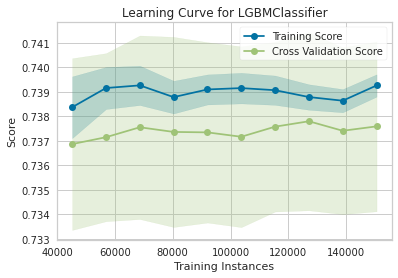

In [24]:
plot_model(lgbm, plot='learning')

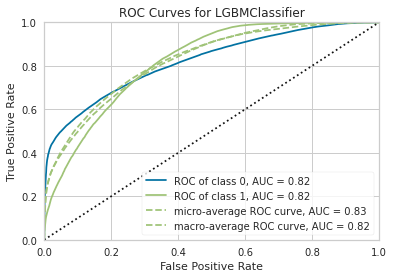

In [25]:
plot_model(lgbm, plot='auc')

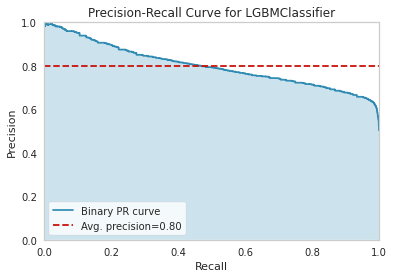

In [26]:
plot_model(lgbm, plot='pr')

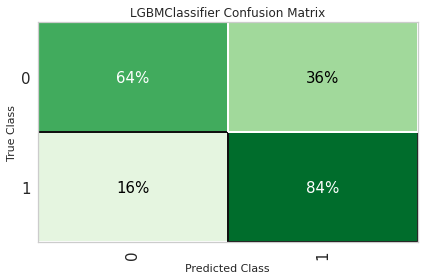

In [27]:
plot_model(lgbm, plot='confusion_matrix',plot_kwargs={'percent':True})

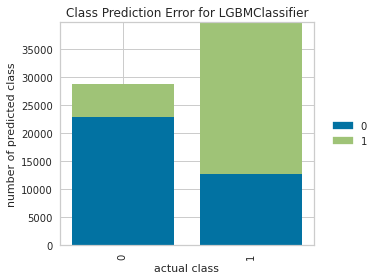

In [28]:
plot_model(lgbm, plot='error')

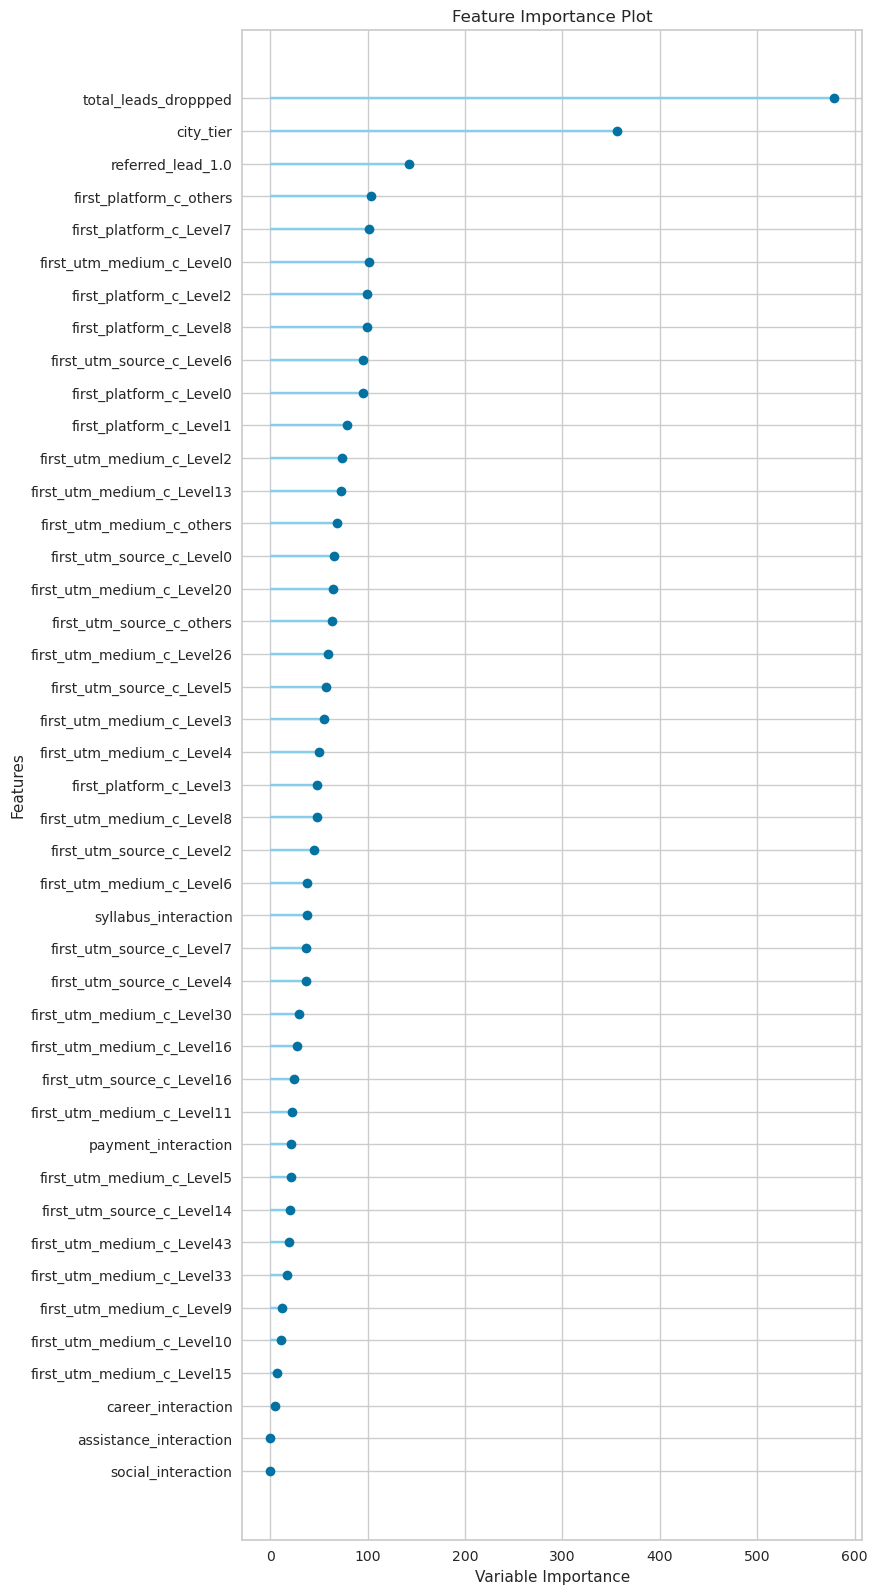

In [29]:
# create feature importance plot
plot_model(lgbm, plot='feature_all')


In [30]:
#xgboost
xgboost = create_model('xgboost',fold=5)

In [31]:
xgboost

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, objective='binary:logistic',
              predictor='auto', random_state=123, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='auto',
              use_label_encoder=True, validate_parameters=1, verbosity=0)

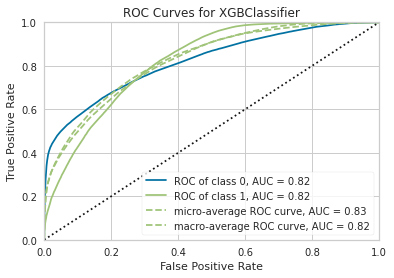

In [32]:
plot_model(xgboost, plot='auc')


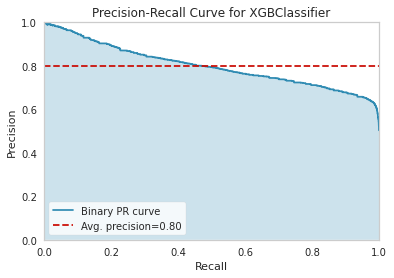

In [33]:
plot_model(xgboost, plot='pr')


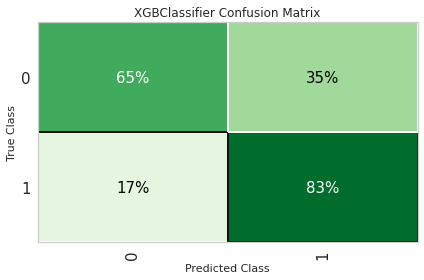

In [34]:
plot_model(xgboost, plot='confusion_matrix',plot_kwargs={'percent':True})


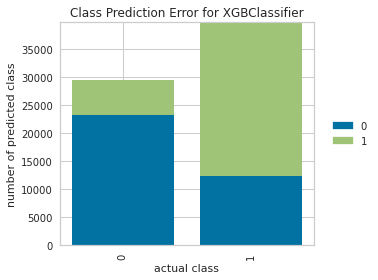

In [35]:
plot_model(xgboost, plot='error')


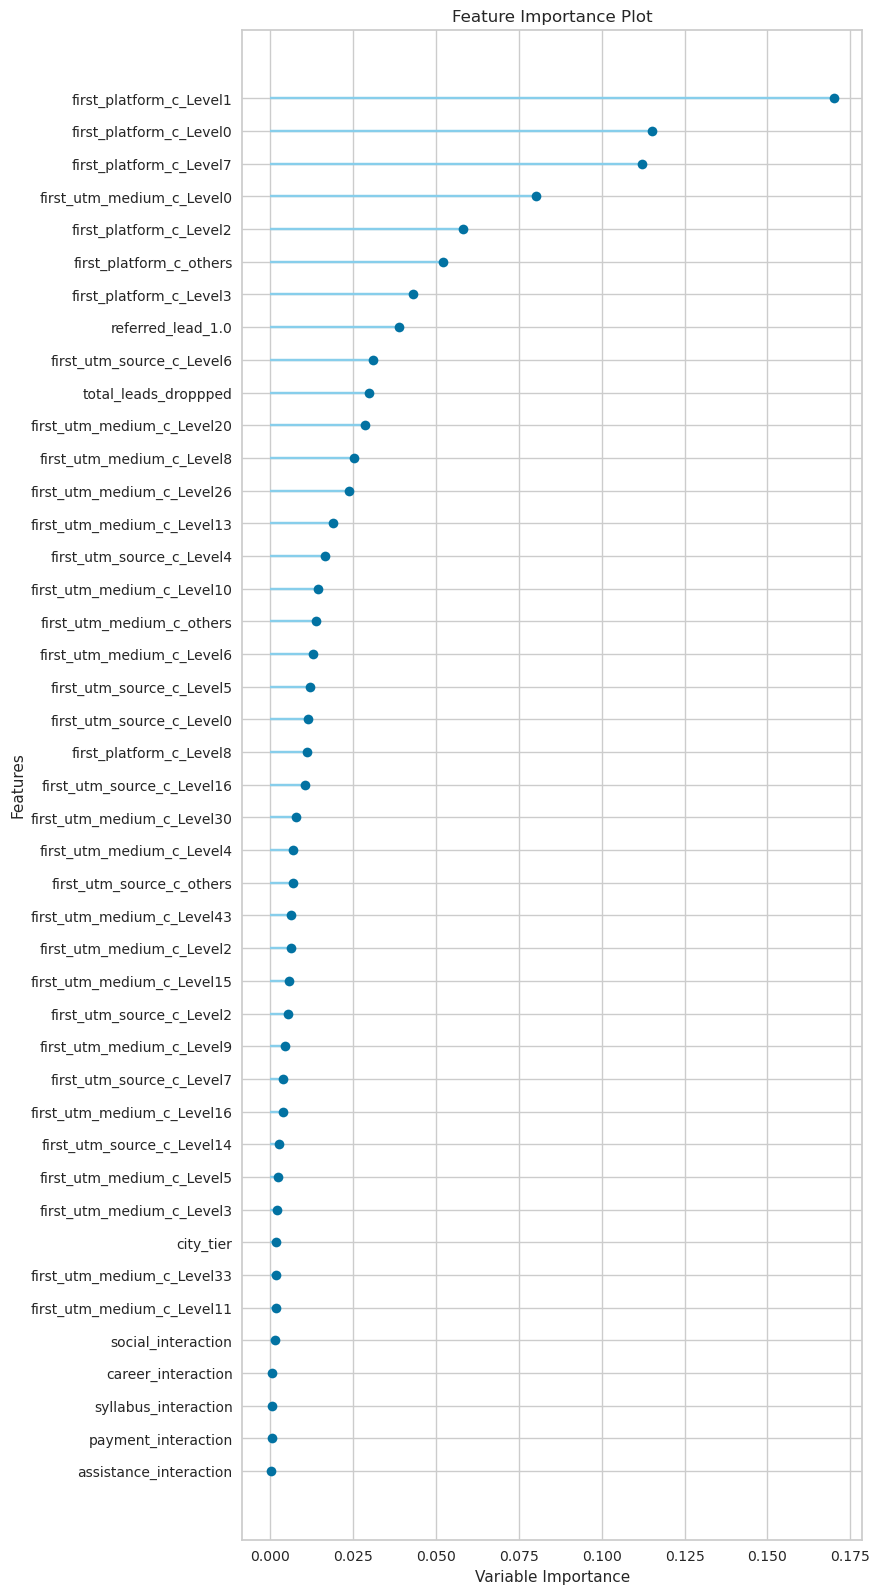

In [36]:
plot_model(xgboost, plot='feature_all')

### 5 : Model Experimentation after dropping features

From the above feature tests we can claerly see that some of the features are not significant. We will now drop all the insignificant features and select only the significant ones.
The list of the significant features is 
['total_leads_droppped', 'city_tier', 'referred_lead', 'app_complete_flag', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c'].
So now you will train your model with onlly these features.

Also note that in our previous experiments we saw that tree based models are our top performers. In case of tree based models we do not require transformationss normalization, scaling etc. So make sure that you use setup pycaret in the proper way. i.e, make sure that you use normalize = False and transformation = False.

In [ ]:
# 
# ['total_leads_droppped', 'city_tier', 'referred_lead', 'app_complete_flag', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c']
#
# Train the model using the features listed above. Since we are using tree models we do not require any transformaions 
# such as normalization, scaling etc.So make sure that you use setup pycaret in the proper way. i.e, make sure that you use 
# normalize = False and transformation = False.

In [37]:
dataset.head()

,city_tier,first_platform_c,first_utm_medium_c,first_utm_source_c,total_leads_droppped,referred_lead,app_complete_flag,assistance_interaction,career_interaction,payment_interaction,social_interaction,syllabus_interaction
0,1.0,Level0,Level11,Level2,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
1,2.0,Level3,Level0,others,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
2,1.0,Level3,Level0,Level0,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0
3,1.0,Level1,Level3,others,2.0,0.0,0,0.0,0.0,0.0,0.0,0.0
4,1.0,Level3,Level0,Level0,1.0,0.0,0,0.0,0.0,0.0,0.0,0.0


In [38]:
new_dataset = dataset[['total_leads_droppped', 'city_tier', 'referred_lead', 'app_complete_flag', 'first_platform_c', 'first_utm_medium_c', 'first_utm_source_c']]


In [39]:
new_dataset.head()

,total_leads_droppped,city_tier,referred_lead,app_complete_flag,first_platform_c,first_utm_medium_c,first_utm_source_c
0,1.0,1.0,0.0,1,Level0,Level11,Level2
1,1.0,2.0,0.0,1,Level3,Level0,others
2,1.0,1.0,0.0,1,Level3,Level0,Level0
3,2.0,1.0,0.0,0,Level1,Level3,others
4,1.0,1.0,0.0,0,Level3,Level0,Level0


In [40]:
treebased_model_exp02 = setup(data=new_dataset, target='app_complete_flag',
                             session_id=123, 
                             log_experiment=True, 
                             log_plots=True,
                             log_data=True,
                             silent=True,
                             verbose=True,
                             log_profile=False,
                             normalize = False,transformation = False,
                             experiment_name='treebased_model_exp02')

,Description,Value
0,session_id,123
1,Target,app_complete_flag
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(238964, 7)"
5,Missing Values,False
6,Numeric Features,2
7,Categorical Features,4
8,Ordinal Features,False
9,High Cardinality Features,False


2023/04/18 19:17:00 INFO mlflow.tracking.fluent: Experiment with name 'treebased_model_exp02' does not exist. Creating a new experiment.


In [41]:
# create a experimentation with pycaret and exclude ['gbc','knn','qda', 'dummy', 'svm', 'ada']. 

best_model2 = compare_models(exclude=['gbc','knn','qda', 'dummy', 'svm', 'ada'], fold=5)


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7372,0.8205,0.8338,0.6997,0.7608,0.4742,0.4833,1.8080
xgboost,Extreme Gradient Boosting,0.7371,0.8205,0.8304,0.7006,0.7600,0.4739,0.4823,7.9940
rf,Random Forest Classifier,0.7359,0.8181,0.8203,0.7027,0.7569,0.4716,0.4784,2.7500
et,Extra Trees Classifier,0.7353,0.8172,0.8149,0.7038,0.7553,0.4704,0.4764,3.3160
dt,Decision Tree Classifier,0.7349,0.8162,0.8143,0.7036,0.7549,0.4697,0.4756,0.1780
lr,Logistic Regression,0.7087,0.7843,0.8228,0.6707,0.7390,0.4170,0.4282,0.9420
ridge,Ridge Classifier,0.6995,0.0000,0.7963,0.6680,0.7265,0.3986,0.4062,0.1820
lda,Linear Discriminant Analysis,0.6995,0.7728,0.7963,0.6680,0.7265,0.3986,0.4062,1.0820
nb,Naive Bayes,0.6741,0.7337,0.8536,0.6289,0.7242,0.3475,0.3723,0.1100


In [ ]:
# You should get lightgbm as the best performing model. So now we will train a lightGBM model manually using pycaret

In [42]:
# create a model which gives the highest accuracy
lightgbm = create_model('lightgbm',fold=10)

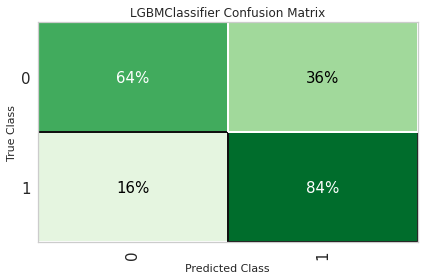

In [43]:
plot_model(lightgbm, plot='confusion_matrix',plot_kwargs={'percent':True})

In [ ]:
# Tune the hyper parameters of the lightgbm model using optuna on 10 folds and optimise AUC as that was our system metric, 
# hence we will optimise AUC



In [44]:
#!pip uninstall optuna

In [48]:

#
!pip install optuna==3.0.0

  Using cached optuna-3.0.0-py3-none-any.whl (348 kB)
  Using cached cmaes-0.9.1-py3-none-any.whl (21 kB)
  Using cached cliff-4.2.0-py3-none-any.whl (81 kB)
  Using cached scipy-1.8.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (41.6 MB)
  Using cached autopage-0.5.1-py3-none-any.whl (29 kB)
  Using cached stevedore-5.0.0-py3-none-any.whl (49 kB)
  Using cached cmd2-2.4.3-py3-none-any.whl (147 kB)
  Using cached pyperclip-1.8.2-py3-none-any.whl
  Using cached pbr-5.11.1-py2.py3-none-any.whl (112 kB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.5.3
    Uninstalling scipy-1.5.3:
      Successfully uninstalled scipy-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyldavis 3.3.1 requires sklearn, which is not installed.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.22.2 which is incompatible.


In [49]:
#pycaret --version
pycaret.__version__

'2.3.8'

In [50]:
import optuna

In [51]:
optuna.__version__

'3.0.0'

In [52]:
tuned_lightgbm_optuna, tuner_1 = tune_model(lightgbm,
                                            search_library = 'optuna',
                                            search_algorithm = 'random',
                                            fold=10,
                                            optimize='AUC',
                                            choose_better=True,
                                            return_tuner=True)

In [53]:
tuned_lightgbm_optuna

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=123, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
# Print the final models configuration so that we can use it in the model retraining pipeline 

In [54]:
print(tuner_1)

OptunaSearchCV(callbacks=None,
               cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
               enable_pruning=False, error_score='raise',
               estimator=Pipeline(memory=None,
                                  steps=[('empty_step', 'passthrough'),
                                         ('actual_estimator',
                                          LGBMClassifier(boosting_type='gbdt',
                                                         class_weight=None,
                                                         colsample_bytree=1.0,
                                                         importance_type='split',
                                                         learning_rate=0.1,
                                                         max_depth=-...
                                    'actual_estimator__reg_alpha': FloatDistribution(high=10.0, log=True, low=1e-10, step=None),
                                    'actual_estimator__